In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [4]:
# a flag
REBUILD_DATA = False

# pre-process data that can be passed into neural network
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "C:\\Users\\ciyua\\pytorch_tutorial_Youtube_sentdex\\kagglecatsanddogs_3367a\\PetImages\\Cat"
    DOGS = "C:\\Users\\ciyua\\pytorch_tutorial_Youtube_sentdex\\kagglecatsanddogs_3367a\\PetImages\\Dog"
    LABELS = {CATS:0, DOGS:1}
    
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:    
            print(label)            # print the key, which is the path
            for f in tqdm(os.listdir(label)):    # os.listdir(path) returns a list of files under the directory(path)
                try:
                    path = os.path.join(label, f)    # join path of directory and image together
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)    # read in grayscale image
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))  # resize image
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])    # np.eye(...): append image and an one-hot vector [1, 0] or [0, 1]
                
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                
                except Exception as e:
                    pass
                
        np.random.shuffle(self.training_data)    
        np.save("training_data.npy", self.training_data)    # Save an array to a binary file in NumPy .npy format.
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)

# read in all images and pre-process them, then save them in a file
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
                

In [29]:
training_data = np.load("training_data.npy", allow_pickle=True)    # load the file which stores images
print(len(training_data))
print(training_data[0])  # [image, one-hot vector]

24946
[array([[167, 172,  91, ..., 110, 122, 139],
       [ 75, 125,  74, ..., 104, 117, 129],
       [131,  42, 194, ..., 141,  77, 117],
       ...,
       [102,  79,  90, ...,  86, 118, 108],
       [ 78,  96,  95, ...,  63, 123,  83],
       [138,  79,  54, ..., 169,  99, 132]], dtype=uint8)
 array([0., 1.])]


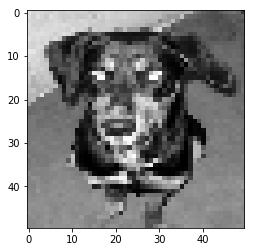

In [10]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap="gray")
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# build the CNN
class Net(nn.Module):    # inherit from base class nn.Module
    def __init__(self):
        super().__init__()    # inherit __init__() from base class "nn.Module" in this subclass's __init__()
        self.conv1 = nn.Conv2d(1, 32, 5)    # 2-D conv layer 1: input 1, output 32, kernel size 5(a 5*5 kernel/filter)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50, 50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear , 512)    # fully connected layer1
        self.fc2 = nn.Linear(512, 2)    # # fully connected layer1
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)    # flatten output after conv
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
net = Net()

torch.Size([128, 2, 2])


In [19]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)    #all parameters will be controlled by the optimizer
loss_function = nn.MSELoss()

# separate Xs and ys
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X / 255.0    # scale pixel value from 0-255 to 0-1
y = torch.Tensor([i[1] for i in training_data])

# separate training and validation data
VAL_PCT = 0.1    #validation dataset percentage 
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [21]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(train_y))
print(len(test_X))
print(len(test_y))

22452
22452
2494
2494


In [ ]:
# train the model
BATCH_SIZE = 100
EPOCHS = 3    # epochs +, accuracy +

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        #print(i, i + BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)

In [ ]:
# calculated the accuracy
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy:", round(correct/total, 3))  # output is 0.6xx